In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import sympy as sp
from matplotlib.ticker import MultipleLocator, FormatStrFormatter ,FuncFormatter
import pandas as pd
from scipy import optimize
from scipy.interpolate import spline 
import os

strt=["1tally  14        nps =   ","1tally  24        nps =   ",
      "1tally  34        nps =   ","1tally  44        nps =   ",
      "1tally  54        nps =   ","1tally  64        nps =   ",]#14 24
un=["g/kg","g/kg","mm","mm","g/cm$^3$","g/cm$^3$","mm","$^{\circ}$$C$"]
st=["o","h","H","s","d","^","<",">","1","2","p"]
c=["r","b","g","c","m","y","k","blueviolet","lightgreen","darkmagenta","lightgreen"]
la=["地层水矿化度($g/kg$)","井眼矿化度($g/kg$)","厚度($mm$)","厚度($mm$)","泥浆密度($g/cm^3$)","泥浆密度($g/cm^3$)","井径($mm$)",
   "井温($^{\circ}$$C$)"]
col=["孔隙度（pu）","近中子计数器-1","近中子计数器-2","远中子计数器-1","远中子计数器-2","远中子计数器-1","远中子计数器-2",
     "第1组远中子计数和","第2组远中子计数和","第1组近远中子比","第2组近远中子比","总近中子计数和","误差","总远中子计数和","误差",
     "总近远中子比"]
def linersmooth7(a): #七点平滑
    b=[]
    N=len(a)-1
    for i in range(3,N-2): #不要前三个和最后三个点
        b.append((130*a[i]+140*(a[i-1]+a[i+1])+65*(a[i-2]+a[i+2])+40*(a[i-3]+a[i+3]))/610) #公式形式
    return b
def dele(a): #y轴去掉了前三个和后三个点，x轴数据也要去掉前三个和后三个
    b=a.copy()
    for i in range(0,3):
        del b[0]
        b.pop()
    return b 

In [2]:
 #用flag给指示是否要将标准情况放入其中
#存在用到标准曲线的情况

In [2]:
data=pd.read_excel("E:\王馨奕\随钻-19-4\MCNP程序及结果\\02-中子图版\\00-标准曲线\\标准曲线.xlsx",index_col=0)
y0=data["总近远中子比"].values#取得标准刻度井计算结果
x0=data["孔隙度（pu）"].values

In [3]:
def rf(flag,x0,excelname):
    path=os.getcwd()
    tn=[[] for i in range(7)]#每个中子计数器的计数值,第一个是记孔隙度值
    jx=[]#文件名-环境变量值
    aimf=[]#目标文件
    ind=[]
    err=[[] for i in range(7)]
    files= os.listdir(path)#读文件名
    for file in files: #遍历文件夹
         if os.path.isdir(file):
                if (file!=".ipynb_checkpoints"):#判断是否是文件夹，是文件夹才打开
                    jx.append(file)
    jx=np.array(jx)#将字符转换为数字，去掉引号
    jx=jx.astype(np.int)#环境因素
    jx.sort()
    for i in range(len(jx)):
        path_dir1="%s"%(jx[i])
        path_list=os.listdir(path_dir1)
        for filename in path_list:
            i=0
            if(i<11):
                if os.path.splitext(filename)[1] == '.o':
                    name=os.path.splitext(filename)[0]
                    aimf.append(name)
                    i+=1
        aimf=np.array(aimf)#将字符转换为数字，去掉引号
        aimf=aimf.astype(np.int)#环境因素
        aimf.sort()
#         print(aimf)
        for i in range(11):#读到的文件文件名做index将中子计数值存储下来
            ind.append(path_dir1)
            tn[0].append(x0[i])#
            err[0].append(x0[i])
            path_dir=path+"\\"+path_dir1+"\\"+"%s.o"%(aimf[i])#读到了含有输出文件的文件路径
            i=0
            j=0
            f=open(path_dir,"r")#读取该文件
            for n in range(6): 
                for line in f:
                    if(line.find(strt[n])!=-1):
                        i=1
                    if(i==1):
                        j+=1
                    if(j==11):
                        m=line.strip()
                        tn[n+1].append(m.split()[0])
                        err[n+1].append(m.split()[1])
                        i=0
                        j=0
                        break
        aimf=[]
    nu=len(tn[0])
#     for i in range(len(tn)):
#         print(len(tn[i]))
    tn=np.array(tn)#将字符转换为数字，去掉引号
    tn=tn.astype(np.float)
    err=np.array(err)#将字符转换为数字，去掉引号
    err=err.astype(np.float)    
    t0=tn.T#nu*6维矩阵转换
    t0=t0.tolist()#numpy to list
    print("已读取到路径%s:文件%s"%(path,jx))
    print("读到%s份输出文件"%(nu))
    for i in range(nu):
#         t0[i].append(tn[0][i])#参考组1
#         t0[i].append(tn[1][i])#参考组2
        t0[i].append(tn[3][i]+tn[5][i])#1组远
        t0[i].append(tn[4][i]+tn[6][i])#2组远
        t0[i].append((tn[1][i])/(tn[3][i]+tn[5][i]))#1组比
        t0[i].append((tn[2][i])/(tn[4][i]+tn[6][i]))#2组比
        t0[i].append(tn[2][i]+tn[1][i])#总近和
        t0[i].append(err[2][i]+err[1][i])#总近和误差
        t0[i].append(tn[6][i]+tn[3][i]+tn[4][i]+tn[5][i])#总远和
        t0[i].append(err[6][i]+err[3][i]+err[4][i]+err[5][i])#总远和
        t0[i].append((tn[2][i]+tn[1][i])/(tn[6][i]+tn[3][i]+tn[4][i]+tn[5][i]))#总比
        R=(tn[2][i]+tn[1][i])/(tn[6][i]+tn[3][i]+tn[4][i]+tn[5][i])
    print("已计算三组近远中子比")
    print("数据存入%s×%s矩阵"%(len(t0),len(t0[0])))
    data=pd.DataFrame(data=t0,index=ind,columns=col)
    data.to_excel("%s.xlsx"%(excelname),encoding="utf_8_sig")
    print("存文件:%s.xlsx"%(excelname))
    if (len(tn[0])==len(t0)):
        print("正确录入数据")
    else:
        print("未正确录入数据")
    return (t0,jx,len(jx),err)

In [4]:
t0,jx,f,err=rf(0,x0,"间隙300")

已读取到路径E:\王馨奕\随钻-19-4\MCNP程序及结果\02-中子图版\4间隙校正\300:文件[ 0  5 10 15 20 25 30 40 50]
读到99份输出文件
已计算三组近远中子比
数据存入99×16矩阵
存文件:间隙300.xlsx
正确录入数据


In [7]:
#画图

In [5]:
def f2(x,A,B,C):
    return A*x*x+B*x+C
def pic1(name_pic,flag):
    x=np.arange(0,55,5)
    D=jx
    d=len(D)
    un=["g/kg","g/kg","mm","mm","g/cm$^3$","g/cm$^3$","mm","$^{\circ}$$C$"]
    st=["o","h","H","s","d","^","<",">","1","2","p"]
    c=["r","b","g","c","m","y","k","blueviolet","lightgreen","darkmagenta","lightgreen"]
    plt.figure(figsize=(6.67, 5), dpi=100) #图片大小：6.75cm×5cm
    plt.rcParams['font.sans-serif']=['SimHei'] #中文默认黑体
    plt.rcParams['axes.unicode_minus']=False #显示负号
    for i in range(6):
        A2,B2,C2=optimize.curve_fit(f2,x,y1[i])[0]
        x2=np.arange(0,50,0.5)
        y2=A2*x2*x2+B2*x2+C2
        plt.plot(x2,y2,color="%s"%(c[i]))
        plt.plot(x,y1[i],"%s"%(st[i]),color="%s"%(c[i]),label="%.1f%s:%.4f×x$^2$%+.2f×x%+.2f"%(D[i],un[flag],A2,B2,C2))
    plt.legend()
    plt.xticks(fontproperties='Times New Roman',fontsize=13)
    plt.yticks(fontproperties='Times New Roman',fontsize=13)
    plt.xlabel("孔隙度($pu$)",fontproperties='SimHei',fontsize=13)
    plt.ylabel("近远热中子比值",fontproperties='SimHei',fontsize=13)
    plt.grid(linewidth='1.5' ,linestyle='-',color="black",alpha=0.5)
    plt.savefig('%s趋势1.png'%(name_pic), format='png', dpi=100,pad_inches=0.0,bbox_inches = 'tight')
    plt.savefig('%s趋势1.svg'%(name_pic), format='svg', dpi=100,pad_inches=0.0,bbox_inches = 'tight')
    plt.show()
    plt.figure(figsize=(6.67, 5), dpi=100) #图片大小：6.75cm×5cm
    plt.rcParams['font.sans-serif']=['SimHei'] #中文默认黑体
    plt.rcParams['axes.unicode_minus']=False #显示负号
    x=np.arange(0,55,5)
    for i in range(0,11):
        A,B,C=optimize.curve_fit(f2,D,[x[i] for x in y1])[0]# l=[0---250] 取不同空隙度对应的比值 横行
        x2=np.arange(min(D),max(D)+0.01,0.01)
        y2=f2(x2,A,B,C)
        plt.plot(x2,y2,color="%s"%(c[i])) #先画拟合的直线，再画实际结果
        plt.plot(D,[x[i] for x in y1],"%s"%(st[i]),color="%s"%(c[i]),label="%spu"%(x[i]),markersize=7)
    plt.xticks(fontproperties='Times New Roman',fontsize=17)
    plt.yticks(fontproperties='Times New Roman',fontsize=17)
    plt.xlabel("%s"%(la[flag]),fontproperties='SimHei',fontsize=17)
    plt.ylabel("近远热中子比值",fontproperties='SimHei',fontsize=17)
    plt.legend(bbox_to_anchor=(1,1.001),borderaxespad=0.1,edgecolor="black",handletextpad=-0.3)
    plt.grid(linewidth='1.5' ,color="black",alpha=0.5)
    plt.savefig('%s趋势2.png'%(name_pic), format='png', dpi=100,pad_inches=0.0,bbox_inches = 'tight')
    plt.savefig('%s趋势2.svg'%(name_pic), format='svg', dpi=100,pad_inches=0.0,bbox_inches = 'tight')
    plt.show()

In [16]:
len(t0[0])

16

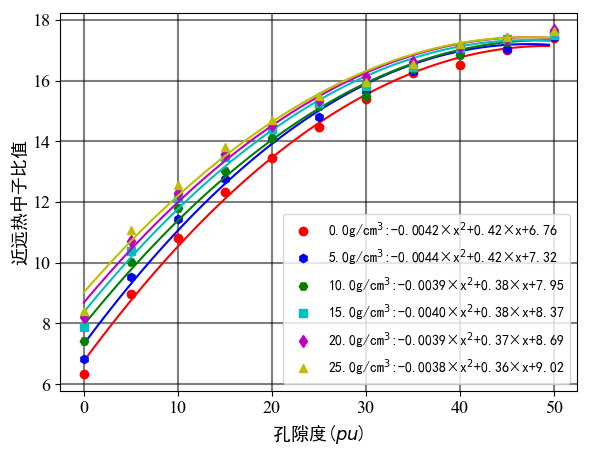

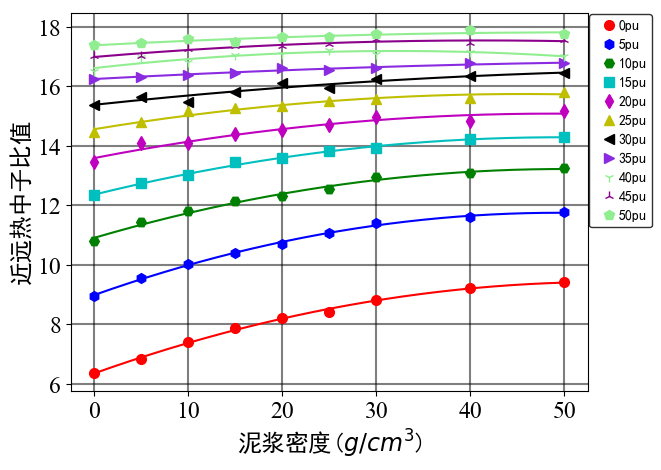

In [6]:
y1=[[] for i in range(f)]
for m in range(f):
    for i in range(len(x0)):
        y1[m].append(t0[i+m*len(x0)][15])#读到的y[0]为标准曲线的值
#     print(len(y1[m]))
pic1("间隙300",3)

In [23]:
def dom(name_pic,flag):
    #计算视孔隙度
    ynew=[]
    x=np.arange(0,55,5)
    for i in range(0,len(jx)):
        co = np.polyfit(y1[i],x,2) # 用多项式拟合
        A2=co[0]
        B2=co[1]
        C2=co[2]
        x2=np.arange(1,20,0.2)
        re = np.polyval(co, x2)
        X=sp.Symbol('X')
        temp=[]
        for j in range(len(x)): #解方程 从近远中子比解孔隙度
            y3=sp.solve(A2*X*X+B2*X+C2-x[j],X) #求出来比值 solve函数
            temp.append(y3[1])
        ynew.append(temp)
    for i in range(len(jx)):
        ynew[i][0]=sp.re(ynew[i][0])+sp.im(ynew[i][0])
    ynew=np.array(ynew)
    pnew=[]
    A,B,C=optimize.curve_fit(f2,y0,x)[0]
    for i in range(len(jx)):
        pnew.append(A*ynew[i]*ynew[i]+B*ynew[i]+C)#带入标准曲线得到视孔隙度7个井径
    plt.figure(figsize=(6.67, 2.5), dpi=100) #图片大小：6.75cm×5cm
    plt.rcParams['font.sans-serif']=['SimHei'] #中文默认黑体
    plt.rcParams['axes.unicode_minus']= False #显示负号
    st=["o","h","H","s","d","^","<",">","1","2","p"]
    c=["r","b","g","c","m","y","k","blueviolet","lightgreen","darkmagenta","lightgreen"]
    pnew=np.array(pnew)
    l=jx
    for i in range(0,11):
        k=[x[i] for x in pnew]
        k=np.array(k,dtype='float')
        plt.plot(k,l,"%s"%(st[i]),color="%s"%(c[i]),markersize=5)#,"%s"%(st[i]),color="%s"%(c[i]),markersize=5
        z1 = np.polyfit(l,k,2) # 用3次多项式拟合
        z = np.polyval(z1, l)
        plt.plot(z,l,"-",color="%s"%(c[i]))       
    plt.xticks(fontproperties='Times New Roman',fontsize=13)
    plt.yticks(fontproperties='Times New Roman',fontsize=13)
    plt.ylabel("%s"%(la[flag]),fontproperties='SimHei',fontsize=13)
    plt.xlabel("孔隙度($pu$)[视石灰岩]",fontproperties='SimHei',fontsize=13)
    #plt.legend(prop=font1,bbox_to_anchor=(1,1.001),borderaxespad=0.1,edgecolor="black",handletextpad=-0.3)
    plt.xlim(0,50)#x轴范围
    plt.ylim(min(l),max(l))
    plt.grid(linewidth='1.5' ,color="black",alpha=0.5)
    # plt.tight_layout()
    plt.savefig('%s校正.png'%(name_pic), format='png', dpi=100,bbox_inches = 'tight')
    plt.savefig('%s校正.svg'%(name_pic), format='svg', dpi=100,bbox_inches = 'tight')
    plt.show()
    plt.figure(figsize=(6.67, 2.5), dpi=100) #图片大小：6.75cm×5cm
    plt.rcParams['font.sans-serif']=['SimHei'] #中文默认黑体
    plt.rcParams['axes.unicode_minus']= False #显示负号
    st=["o","h","H","s","d","^","<",">","1","2","p"]
    c=["r","b","g","c","m","y","k","blueviolet","lightgreen","darkmagenta","lightgreen"]
    pnew=np.array(pnew)
    l=jx
    for i in range(0,11):
        k=[x[i] for x in pnew]
        k=np.array(k,dtype='float')
        z1 = np.polyfit(l,k,2) # 用3次多项式拟合
        z = np.polyval(z1, l)
        plt.plot(z,l,"-",color="#054E9F")       
    plt.xticks(fontproperties='Times New Roman',fontsize=13)
    plt.yticks(fontproperties='Times New Roman',fontsize=13)
    plt.ylabel("%s"%(la[flag]),fontproperties='SimHei',fontsize=13)
    plt.xlabel("孔隙度($pu$)[视石灰岩]",fontproperties='SimHei',fontsize=13)
    #plt.legend(prop=font1,bbox_to_anchor=(1,1.001),borderaxespad=0.1,edgecolor="black",handletextpad=-0.3)
    plt.xlim(0,50)#x轴范围
    plt.ylim(min(l),max(l))
    plt.grid(linewidth='1.5' ,color="black",alpha=0.5)
    # plt.tight_layout()
    plt.savefig('%s校正2.png'%(name_pic), format='png', dpi=100,bbox_inches = 'tight')
    plt.savefig('%s校正2.svg'%(name_pic), format='svg', dpi=100,bbox_inches = 'tight')
    plt.show()

In [24]:
dom("间隙250",1)

NameError: name 'solve' is not defined